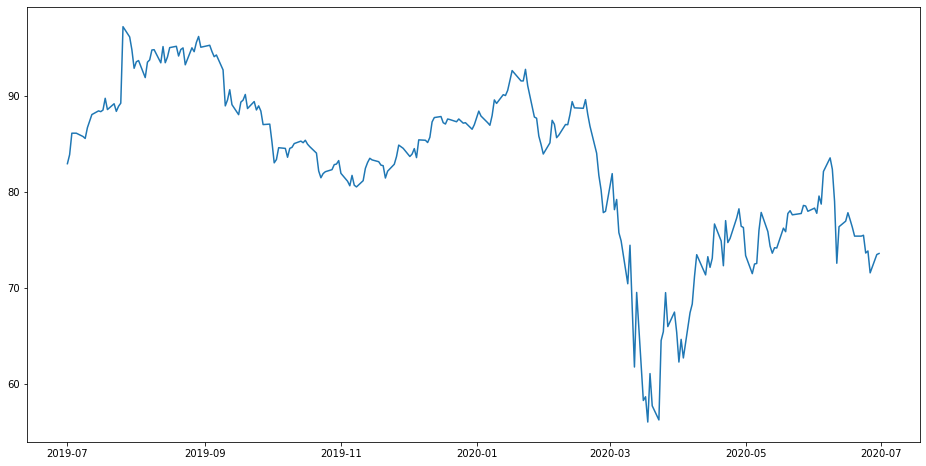

In [12]:

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import smtplib
import time
import datetime as dt
import sklearn
from selenium import webdriver #For Prediction
from sklearn.linear_model import LinearRegression
from pandas_datareader import data as wb
import warnings
warnings.simplefilter("ignore")


#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

start = '2019-6-30'
end = '2020-6-30'
#end = dt.datetime.today()

tickers = ['SBUX']
price_data = []
for ticker in tickers:
    prices = wb.DataReader(ticker, start = start, end = end, data_source='yahoo')[['Adj Close']]
    price_data.append(prices.assign(ticker=ticker)[['ticker', 'Adj Close']])

df = pd.concat(price_data)
df.dtypes
df.head()
df.shape

df = df.reset_index()
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'], label='Close Price history')


In [13]:

#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Adj Close'][i] = data['Adj Close'][i]


#splitting into train and validation
train = new_data[:200] # get first 200
valid = new_data[-50:] # get last 50

new_data.shape, train.shape, valid.shape


train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()


#make predictions
preds = []
for i in range(0,50):
    a = train['Adj Close'][len(train)-50+i:].sum() + sum(preds)
    b = a/50
    preds.append(b)
    
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['Adj Close'])-preds),2)))
print(rms)


7.1191612708696805


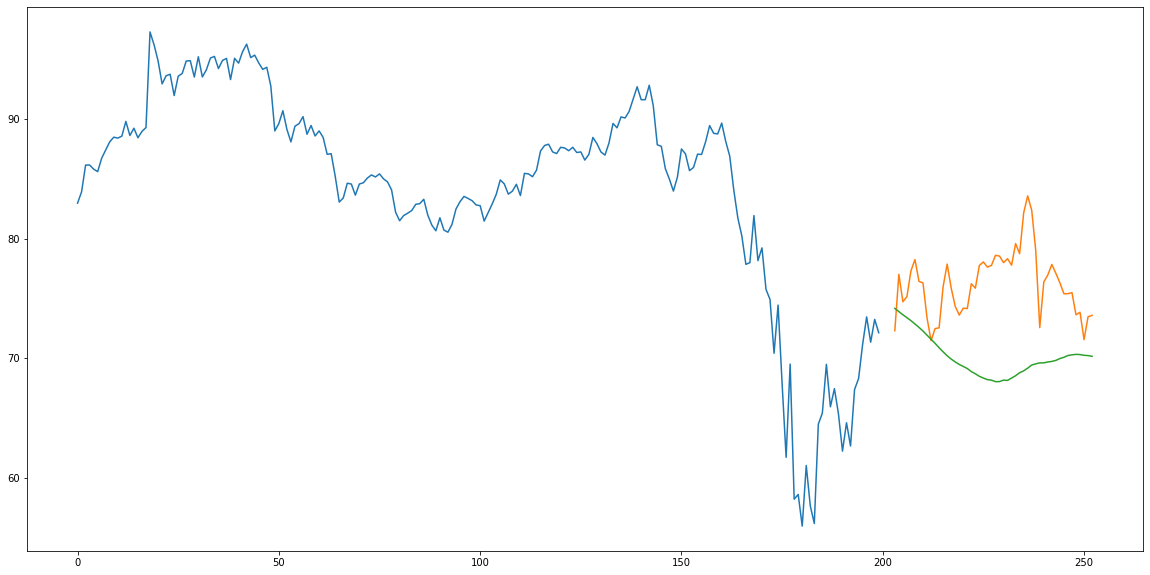

In [14]:

#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])


In [15]:

# In statistics, linear regression is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables).  The case of one explanatory variable is called simple linear regression. 

# Linear Regression; most basic machine learning algorithm that can be implemented we can add our own set of features that we believe would be relevant for the predictions.  For instance, my hypothesis is that the first and last  days of the week could potentially affect the closing price of the stock far more than the other days.  So I have created a feature that identifies whether a given day is Monday/Friday or Tuesday/Wednesday/Thursday. 

# setting index as date values
data = df.sort_index(ascending=True, axis=0)
df['day_of_week'] = df['Date'].dt.dayofweek


df['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (df['day_of_week'][i] == 0 or df['day_of_week'][i] == 4):
        df['mon_fri'][i] = 1
    else:
        df['mon_fri'][i] = 0
        
        
#split into train and validation
train = df[:200]
valid = df[-50:]

train.shape
valid.shape

train.dtypes
# copy fields over from dataframe
x_train = train[['Adj Close','mon_fri']].copy()
y_train = train[['Adj Close','mon_fri']].copy()
x_valid = valid[['Adj Close','mon_fri']].copy()
y_valid = valid[['Adj Close','mon_fri']].copy()

#implement linear regression
from sklearn.linear_model import LinearRegression
#df = df.drop(['Date'], axis=1)
#df.dtypes
#df = df.reset_index()

model = LinearRegression()
model.fit(x_train,y_train)


#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print(rms)


5.503849748337105e-15


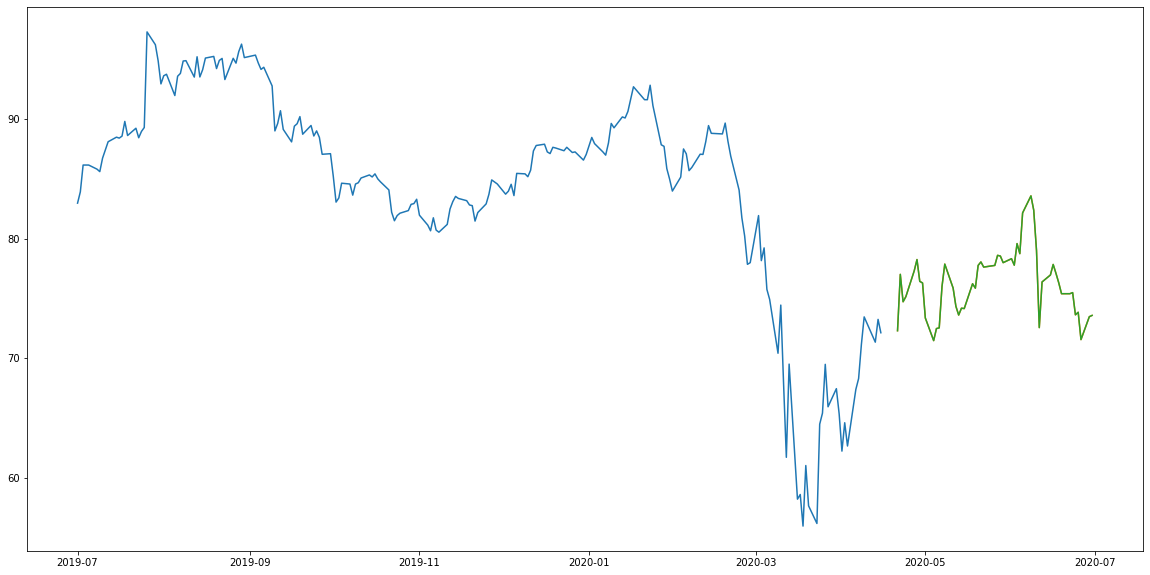

In [16]:

#plot
valid['Predictions'] = 0
valid['Predictions'] = preds


plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])


In [19]:
# k-NN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until function evaluation. Since this algorithm relies on distance for classification, normalizing the training data can improve its accuracy dramatically.

# Both for classification and regression, a useful technique can be to assign weights to the contributions of the neighbors, so that the nearer neighbors contribute more to the average than the more distant ones.  For example, a common weighting scheme consists in giving each neighbor a weight of 1/d, where d is the distance to the neighbor.

# k-nearest neighbors
# importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)


#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print(rms)



5.114806497716794


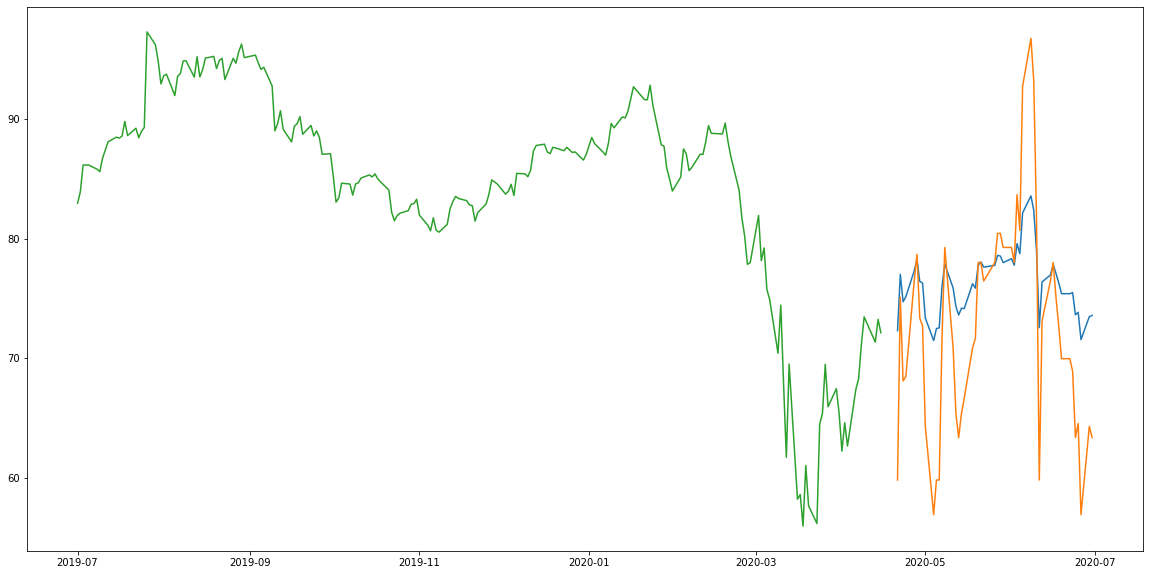

In [18]:

#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Adj Close', 'Predictions']])
plt.plot(train['Adj Close'])


In [ ]:

# data:
# All data is imported from Yahoo Finance.  Yahoo sources the data from Capital IQ.